<h1>ECE521 Assignment 3</h1>

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<h2>Utils</h2>

In [2]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.
     
     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(input_tensor, 
                                    reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, 
                                       reduction_indices) 
  return tf.log(tf.reduce_sum(tf.exp(input_tensor - max_input_tensor2), 
                                reduction_indices, keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     
 
  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, keep_dims=True)

<h2>1</h2>

<h3>1.1.2</h3>

In [4]:
data = np.load("../data/data2D.npy")
points_2d = data
x = points_2d[:,0]
y = points_2d[:,1]
print(x)
print(y)

[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


In [4]:
def buildGraph_K_means_Adam(K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 2], name='input_points')
    centroids = tf.Variable(tf.truncated_normal(shape=[K,2], stddev=0.5), name='centroids')
    N = tf.shape(points)[0]
    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 2])
    rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, 2])
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), reduction_indices=2)
    best_centroids = tf.argmin(sum_squares, 1)
    count = tf.to_float(tf.unsorted_segment_sum(tf.ones_like(points), best_centroids, K))
    percentage = tf.div(count, tf.to_float(N))
    # Loss definition
    indices_pair = tf.concat(1, [tf.reshape(tf.range(0, N), [-1,1]), tf.to_int32(tf.reshape(best_centroids, [-1,1]))])
    loss = tf.reduce_sum(tf.gather_nd(sum_squares, indices_pair))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, centroids, best_centroids, loss, percentage, train

In [6]:
a = tf.constant([[1,1],[0,0],[1,0]])
b = tf.constant([1,0,1])
indices_pair = tf.reshape(tf.range(0, 3), [-1,1])
concated = tf.concat(1, [indices_pair, tf.reshape(b, [-1,1])])
#concated = tf.reshape(concated, [-1,2])
sess = tf.InteractiveSession()
sess.run(concated)

array([[0, 1],
       [1, 0],
       [2, 1]], dtype=int32)

In [39]:
Number_of_data = points_2d.shape[0]
# fix figure size
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


C:\Users\lidai\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pi', 'dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Iteration#: 0, loss: 49955.54
Iteration#: 100, loss: 21729.39
Iteration#: 200, loss: 11372.34
Iteration#: 300, loss: 6658.28
Iteration#: 400, loss: 5387.73


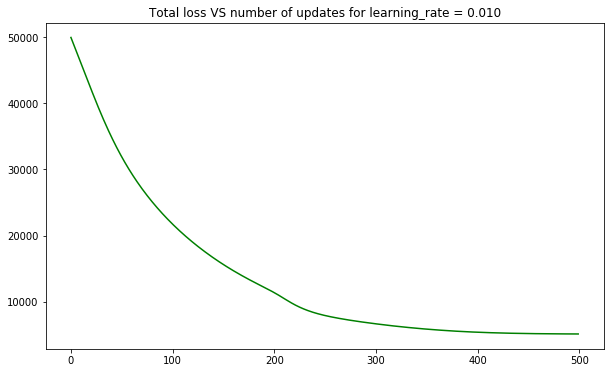

In [8]:
learning_rate = 0.01
points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(3, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
loss_recorder = np.array([])

numIteration = 500
for itr in range(numIteration):
    loss_, _ = sess.run([loss, train], feed_dict={points: points_2d})
    loss_recorder = np.append(loss_recorder, loss_)
    if itr % 100 == 0:
        print("Iteration#: %d, loss: %0.2f"%(itr, loss_))
plt.plot(np.arange(numIteration), loss_recorder, 'g')
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

<h3>1.1.3</h3>

Number of cluster: 1, loss: 79110.28
Number of cluster: 1, loss: 48838.28
Number of cluster: 1, loss: 39954.02
Number of cluster: 1, loss: 38506.54
Number of cluster: 1, loss: 38453.55
Number of cluster: 1, loss: 38453.48
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Percentage for different clusters:
Total K is 1, cluster 0: 1.00
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


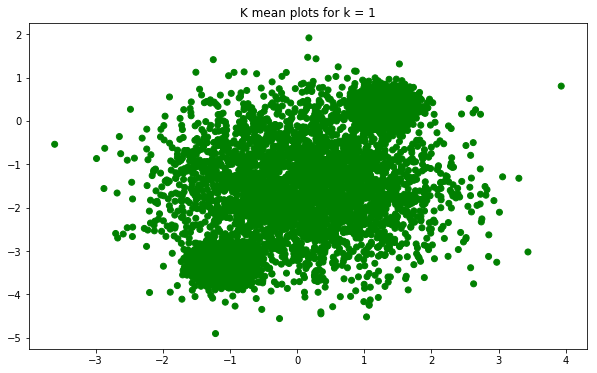

Number of cluster: 2, loss: 63469.20
Number of cluster: 2, loss: 28351.79
Number of cluster: 2, loss: 15129.37
Number of cluster: 2, loss: 10580.23
Number of cluster: 2, loss: 9371.68
Number of cluster: 2, loss: 9208.53
Number of cluster: 2, loss: 9203.37
Number of cluster: 2, loss: 9203.35
Number of cluster: 2, loss: 9203.36
Number of cluster: 2, loss: 9203.35
Percentage for different clusters:
Total K is 2, cluster 0: 0.50
Total K is 2, cluster 1: 0.50
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


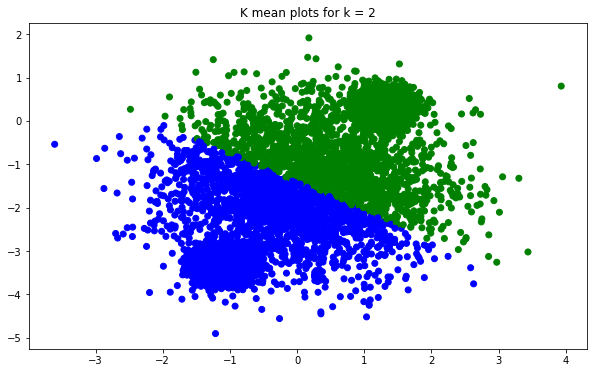

Number of cluster: 3, loss: 55134.23
Number of cluster: 3, loss: 24328.44
Number of cluster: 3, loss: 12597.96
Number of cluster: 3, loss: 7184.71
Number of cluster: 3, loss: 5582.89
Number of cluster: 3, loss: 5145.17
Number of cluster: 3, loss: 5111.32
Number of cluster: 3, loss: 5111.07
Number of cluster: 3, loss: 5111.07
Number of cluster: 3, loss: 5111.07
Percentage for different clusters:
Total K is 3, cluster 0: 0.38
Total K is 3, cluster 1: 0.38
Total K is 3, cluster 2: 0.24
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


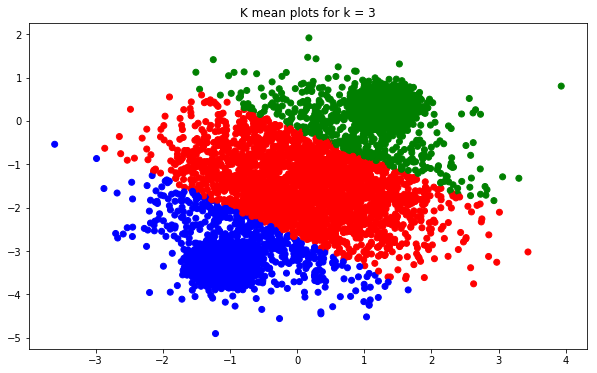

Number of cluster: 4, loss: 50871.99
Number of cluster: 4, loss: 22985.76
Number of cluster: 4, loss: 10039.87
Number of cluster: 4, loss: 5412.84
Number of cluster: 4, loss: 3737.19
Number of cluster: 4, loss: 3397.36
Number of cluster: 4, loss: 3374.14
Number of cluster: 4, loss: 3374.04
Number of cluster: 4, loss: 3374.03
Number of cluster: 4, loss: 3374.04
Percentage for different clusters:
Total K is 4, cluster 0: 0.13
Total K is 4, cluster 1: 0.37
Total K is 4, cluster 2: 0.37
Total K is 4, cluster 3: 0.12
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


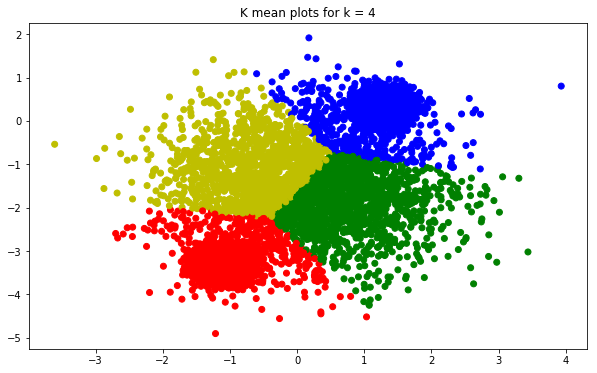

Number of cluster: 5, loss: 32920.80
Number of cluster: 5, loss: 12016.47
Number of cluster: 5, loss: 4723.19
Number of cluster: 5, loss: 3137.42
Number of cluster: 5, loss: 2890.58
Number of cluster: 5, loss: 2874.28
Number of cluster: 5, loss: 2874.01
Number of cluster: 5, loss: 2874.01
Number of cluster: 5, loss: 2874.01
Number of cluster: 5, loss: 2874.01
Percentage for different clusters:
Total K is 5, cluster 0: 0.09
Total K is 5, cluster 1: 0.07
Total K is 5, cluster 2: 0.36
Total K is 5, cluster 3: 0.12
Total K is 5, cluster 4: 0.36
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


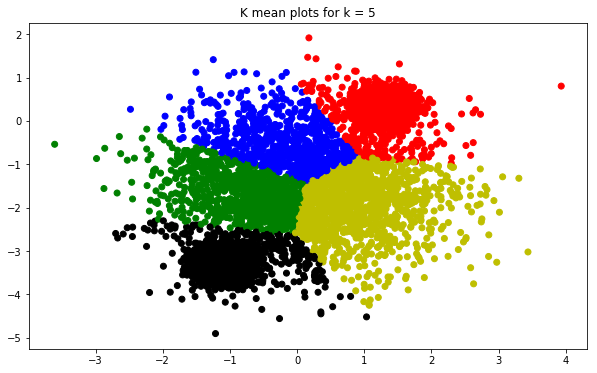

In [21]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])

    numIteration = 1000
    P = []
    assign = []
    for itr in range(numIteration):
        loss_, P, assign, _ = sess.run([loss, percentage, centroids_assign, train], feed_dict={points: points_2d})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, loss: %0.2f"%(K, loss_))
    print("Percentage for different clusters:")
    for k in range(K):
        print("Total K is %d, cluster %d: %0.2f"%(K, k, P[k][0])) 
    x = points_2d[:,0]
    y = points_2d[:,1]
    colors = [color_list[assign[i]] for i in range(Number_of_data)]
    plt.scatter(x,y,c=colors)
    #plt.axis([0,500, 0, 2])
    plt.title("K mean plots for k = %d"%(K))
    plt.show()

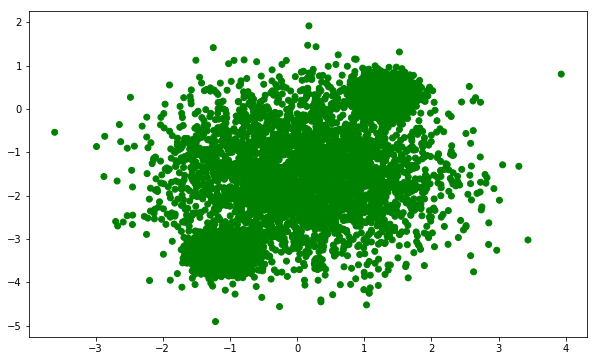

In [23]:
x = points_2d[:,0]
y = points_2d[:,1]
colors = ["g" for i in points_2d[:,0]]
plt.scatter(x,y,c=colors)

<h3>1.1.4</h3>

In [37]:
validSize = int(Number_of_data * 1.0 / 3.0)
validData = points_2d[:validSize,:]
trainData = points_2d[validSize:,:]
print(validData)

[[ 1.69424762 -2.4385797 ]
 [ 1.12750805 -2.06013747]
 [ 2.40075462 -2.96636567]
 ..., 
 [ 1.34861077  0.21586008]
 [-0.33089382 -2.13849022]
 [ 1.47810309  0.71745904]]


Number of cluster: 1, Iteration#: 0, Validation loss: 21494.57
Number of cluster: 1, Iteration#: 100, Validation loss: 14248.43
Number of cluster: 1, Iteration#: 200, Validation loss: 12833.39
Number of cluster: 1, Iteration#: 300, Validation loss: 12752.72
Number of cluster: 1, Iteration#: 400, Validation loss: 12753.20


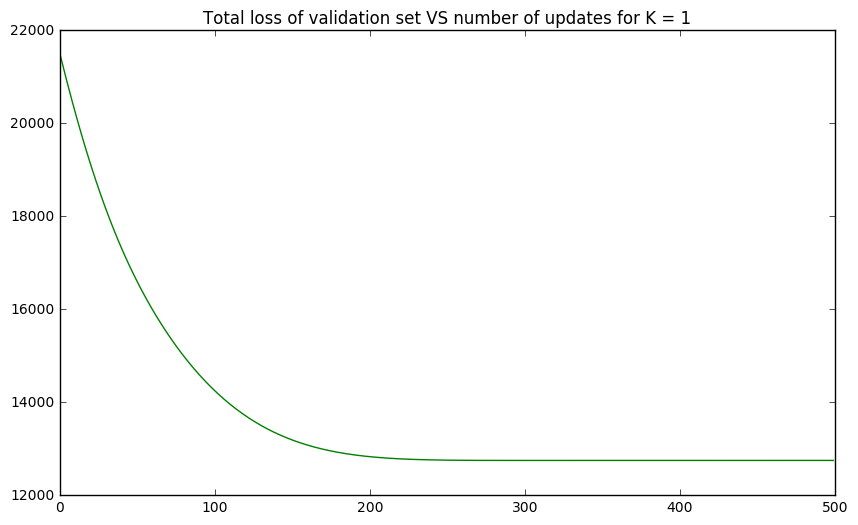

Number of cluster: 2, Iteration#: 0, Validation loss: 18969.51
Number of cluster: 2, Iteration#: 100, Validation loss: 8136.72
Number of cluster: 2, Iteration#: 200, Validation loss: 4489.36
Number of cluster: 2, Iteration#: 300, Validation loss: 3320.94
Number of cluster: 2, Iteration#: 400, Validation loss: 3050.72


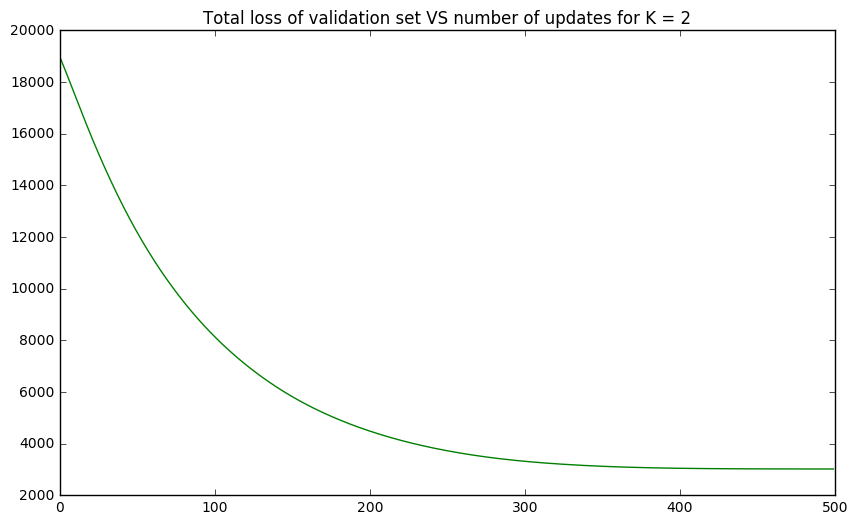

Number of cluster: 3, Iteration#: 0, Validation loss: 15694.48
Number of cluster: 3, Iteration#: 100, Validation loss: 6860.39
Number of cluster: 3, Iteration#: 200, Validation loss: 3233.75
Number of cluster: 3, Iteration#: 300, Validation loss: 2172.90
Number of cluster: 3, Iteration#: 400, Validation loss: 1729.28


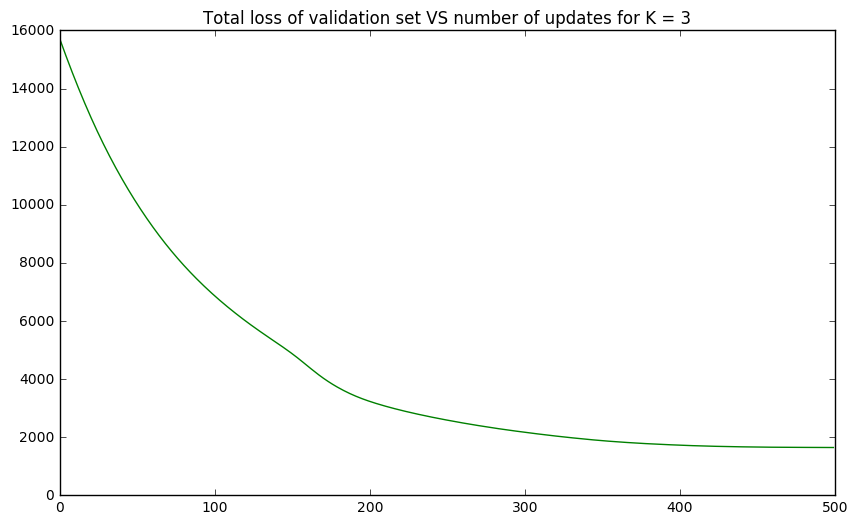

Number of cluster: 4, Iteration#: 0, Validation loss: 12580.76
Number of cluster: 4, Iteration#: 100, Validation loss: 5048.21
Number of cluster: 4, Iteration#: 200, Validation loss: 2290.29
Number of cluster: 4, Iteration#: 300, Validation loss: 1362.81
Number of cluster: 4, Iteration#: 400, Validation loss: 1131.13


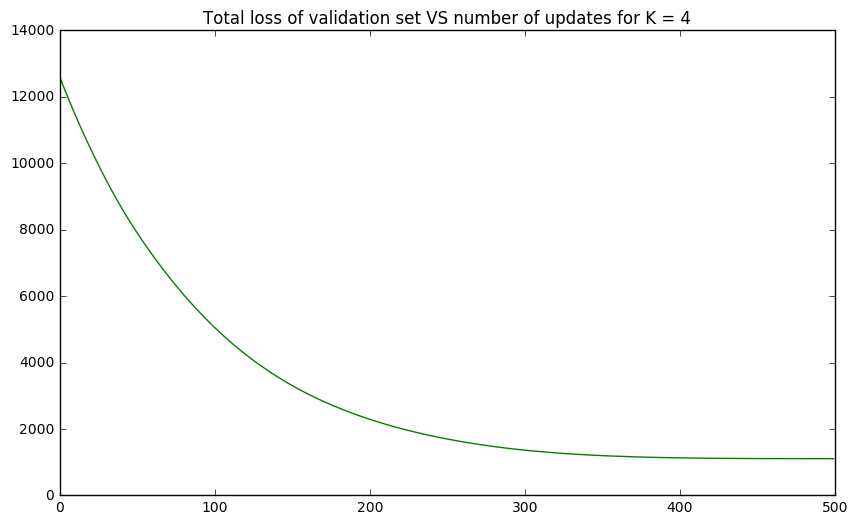

Number of cluster: 5, Iteration#: 0, Validation loss: 15599.42
Number of cluster: 5, Iteration#: 100, Validation loss: 6321.72
Number of cluster: 5, Iteration#: 200, Validation loss: 2709.74
Number of cluster: 5, Iteration#: 300, Validation loss: 1407.25
Number of cluster: 5, Iteration#: 400, Validation loss: 1019.40


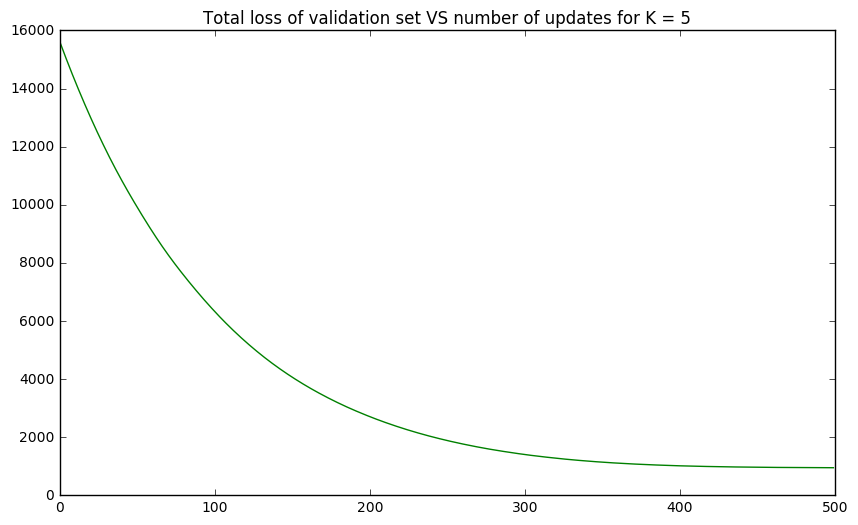

In [186]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    
    numIteration = 500
    for itr in range(numIteration):
        _ = sess.run([train], feed_dict={points: trainData})
        loss_ = sess.run(loss, feed_dict={points: validData})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, Iteration#: %d, Validation loss: %0.2f"%(K, itr, loss_))
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss of validation set VS number of updates for K = %d"%(K))
    plt.show()

<h3>2.1.2</h3>

In [131]:
def get_log_gaussian(X, mu, diag_stdev):
    '''
    X: BxD
    mu: KxD
    diag_stdev: KxD
    B: number of data points
    D: dimension of a data point
    K: number of clusters
    return BxK matrix
    '''
    B = tf.shape(X)[0]
    D = tf.shape(X)[1]
    K = tf.shape(mu)[0]
    rep_X = tf.reshape(tf.tile(X, [1, K]), [B, K, D])
    dist = tf.contrib.distributions.MultivariateNormalDiag(mu, diag_stdev)
    return dist.log_pdf(rep_X)
    

In [92]:
mu = tf.constant([[1.0,3.0],[5.0,2.0],[1.0,3.0]], dtype=tf.float64)
diag_stdev = tf.constant([[1.0,1.0], [1.0,1.0],[1.0,1.0]], dtype=tf.float64)
X = tf.placeholder(tf.float64, [None, 2])
dist = get_log_gaussian(X, mu, diag_stdev)

sess = tf.InteractiveSession()
sess.run(dist, feed_dict={X: points_2d})

array([[-16.86794151, -17.15237132, -16.86794151],
       [-14.64850181, -17.57833214, -14.64850181],
       [-20.61769351, -17.54830934, -20.61769351],
       ..., 
       [-24.63118986, -35.19536871, -24.63118986],
       [ -6.10012272,  -9.38913378,  -6.10012272],
       [ -5.65596292,  -9.94046048,  -5.65596292]])

<h3>2.1.3</h3>

In [135]:
def get_log_P_Z_given_X(X, pi, mu, diag_stdev):
    '''
    X: BxD
    pi: 1xK
    mu: KxD
    diag_stdev: KxD
    B: number of data points
    D: dimension of a data point
    K: number of clusters
    return BxK matrix
    '''
    B = tf.shape(X)[0]
    D = tf.shape(X)[1]
    K = tf.shape(mu)[0]
    rep_pi = tf.reshape(tf.tile(pi, [1,B]), [B, K])
    log_gaussian = get_log_gaussian(X, mu, diag_stdev)
    res = logsoftmax(rep_pi + log_gaussian)
    return res
    

In [110]:
mu = tf.constant([[1.0,3.0],[5.0,2.0]], dtype=tf.float64)
diag_stdev = tf.constant([[1.0], [1.0]], dtype=tf.float64)
pi = logsoftmax(tf.constant([[0.5,0.5]], dtype=tf.float64))
X = tf.placeholder(tf.float64, [None, 2])
res = get_log_P_Z_given_X(X, pi, mu, diag_stdev)

sess = tf.InteractiveSession()
sess.run(res, feed_dict={X: points_2d})

array([[ -5.61010909e-01,  -8.45440722e-01],
       [ -5.20288178e-02,  -2.98185915e+00],
       [ -3.11478742e+00,  -4.54032457e-02],
       ..., 
       [ -2.58243746e-05,  -1.05642047e+01],
       [ -3.66122269e-02,  -3.32562329e+00],
       [ -1.36864553e-02,  -4.29818402e+00]])

<h3>2.2.2</h3>

In [98]:
def get_log_P(X, pi, mu, diag_stdev):
    '''
    X: BxD
    pi: 1xK
    mu: KxD
    diag_stdev: Kx1
    B: number of data points
    D: dimension of a data point
    K: number of clusters
    return float64
    '''
    B = tf.shape(X)[0]
    D = tf.shape(X)[1]
    K = tf.shape(mu)[0]
    rep_pi = tf.reshape(tf.tile(pi, [1,B]), [B, K])
    log_gaussian = get_log_gaussian(X, mu, diag_stdev)
    res = tf.reduce_sum(reduce_logsumexp(rep_pi + log_gaussian))
    return res

In [101]:
K = 2
mu = tf.Variable(tf.truncated_normal(shape=[K,2], stddev=0.5), name='mu_test')
diag_stdev = tf.Variable(tf.exp(tf.truncated_normal(shape=[K,1], stddev=0.5)), name='diag_stdev_test')
phi = tf.Variable(tf.div(tf.ones(shape=[1,K]), K), name='phi_test')
pi = logsoftmax(phi)
X = tf.placeholder(tf.float32, [None, 2])
res = get_log_P(X, pi, mu, diag_stdev)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
#sess.run(tf.shape(mu)[0])
sess.run(res, feed_dict={X: points_2d})

-47012.844

In [128]:
def buildGraph_MoG_Adam_2d(K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 2], name='input_points')
    mu = tf.Variable(tf.truncated_normal(shape=[K,2], stddev=0.5), name='mu')
    diag_stdev = tf.Variable(tf.exp(tf.truncated_normal(shape=[K,2], stddev=0.5)), name='diag_stdev')
    phi = tf.Variable(tf.truncated_normal(shape=[1,K], stddev=0.5), name='phi')
    pi = logsoftmax(phi)
    
    # Loss definition
    loss = -get_log_P(points, pi, mu, diag_stdev)
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, pi, mu, diag_stdev, loss, train

Iteration#: 0, loss: 45946.19
Mean matrix is:
[[-0.08980971  0.2301439 ]
 [-0.02299434  0.08443027]
 [ 0.30562559 -0.70668489]
 [ 0.3117786  -0.24328083]
 [-0.05765156  0.16719832]]
diag_stdev is:
[[ 1.54685235  1.6269747 ]
 [ 0.91185081  0.96239316]
 [ 1.05601144  0.96491307]
 [ 0.38663089  1.40135694]
 [ 0.7004016   0.6435101 ]]
pi is:
[[-2.37618423 -1.32800436 -1.38714623 -1.64674008 -1.61131048]]
Iteration#: 100, loss: 27815.69
Mean matrix is:
[[-0.67295903 -0.39442551]
 [ 0.42280975 -0.66073507]
 [-0.76947534 -1.59307694]
 [ 1.09179533 -0.7855944 ]
 [ 0.95238429  0.31044978]]
diag_stdev is:
[[ 0.84609872  2.07518935]
 [ 1.09455013  1.489972  ]
 [ 0.53861737  1.50433552]
 [ 0.67422545  1.08224559]
 [ 0.59999847  0.17819774]]
pi is:
[[-2.49960566 -2.26207256 -0.76794612 -2.35405207 -1.36727738]]
Iteration#: 200, loss: 21840.66
Mean matrix is:
[[-0.49949074 -0.64849377]
 [ 0.47456402 -1.19395137]
 [-1.09301877 -2.32842827]
 [ 0.51197946 -1.70519114]
 [ 1.30056775  0.30849254]]
diag_s

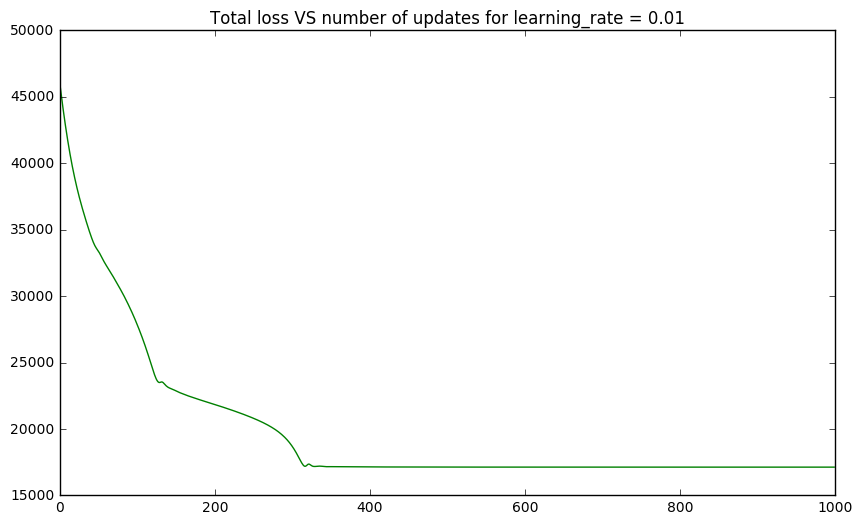

In [129]:
learning_rate = 0.01
points, pi, mu, diag_stdev, loss, train = buildGraph_MoG_Adam_2d(5, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
loss_recorder = np.array([])

numIteration = 1000
best_pi = []
for itr in range(numIteration):
    loss_, best_pi, mu_, diag_stdev_, _ = sess.run([loss, pi, mu, diag_stdev, train], feed_dict={points: points_2d})
    loss_recorder = np.append(loss_recorder, loss_)
    if itr % 100 == 0:
        print("Iteration#: %d, loss: %0.2f"%(itr, loss_))
        print("Mean matrix is:")
        print(mu_)
        print("diag_stdev is:")
        print(diag_stdev_)
        print("pi is:")
        print(best_pi)
best_pi = sess.run(tf.exp(best_pi))
print("The best pi values are:")
print(best_pi)
plt.plot(np.arange(numIteration), loss_recorder, 'g')
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.2f"%(learning_rate))
plt.show()

<h3>2.2.3</h3>

In [105]:
def get_MoG_assign(X, pi, mi, diag_stdev):
    assign = tf.argmax(get_log_P_Z_given_X(X, pi, mu, diag_stdev), 1)
    return assign

In [136]:
trainData.shape

(6667, 2)

In [ ]:
def plot_ellipse(mean, cov_sqrt, alpha, num_points=100):
    angles = np.linspace(0, 2*np.pi, num_points)
    circle_pts = np.vstack([np.cos(angles), np.sin(angles)]).T * 2.0
    cur_pts = mean + np.dot(circle_pts, cov_sqrt)
    plt.plot(cur_pts[:, 0], cur_pts[:, 1], '-', alpha=alpha

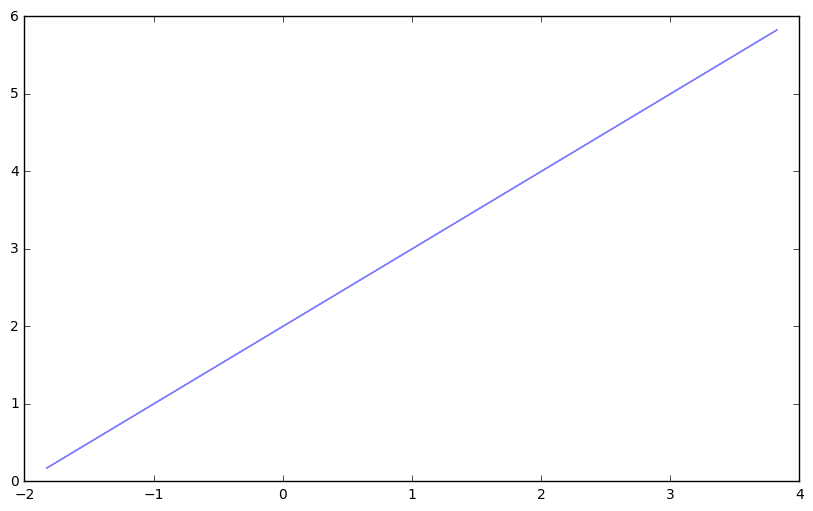

In [138]:
mu = tf.constant([[1.0,3.0],[5.0,2.0]], dtype=tf.float64)
diag_stdev = tf.constant([[1.0,1.0], [1.0,1.0]], dtype=tf.float64)
rep_diag_stdev = tf.reshape(tf.tile(diag_stdev, [1,2]), [2,2,2])
mu_, rep_diag_stdev = sess.run([mu, rep_diag_stdev])
plot_ellipse(mu_[0], rep_diag_stdev[0], 0.5)
plt.show()

Number of cluster: 1, Iteration#: 0, Validation loss: 19095.86
Number of cluster: 1, Iteration#: 100, Validation loss: 12269.24
Number of cluster: 1, Iteration#: 200, Validation loss: 11646.35
Number of cluster: 1, Iteration#: 300, Validation loss: 11476.17
Number of cluster: 1, Iteration#: 400, Validation loss: 11445.05
Number of cluster: 1, Iteration#: 500, Validation loss: 11444.39
diag_stdev:  [[ 1.14889252  1.59212542]]
pi:  [[ 1.]]


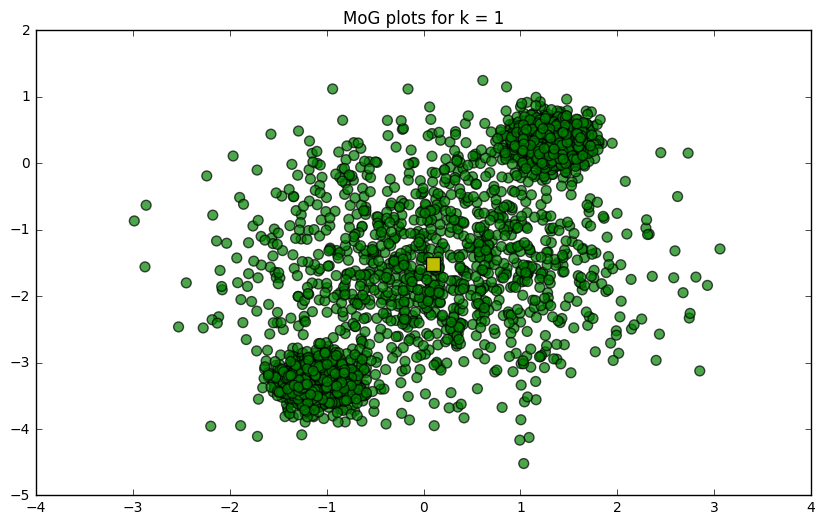

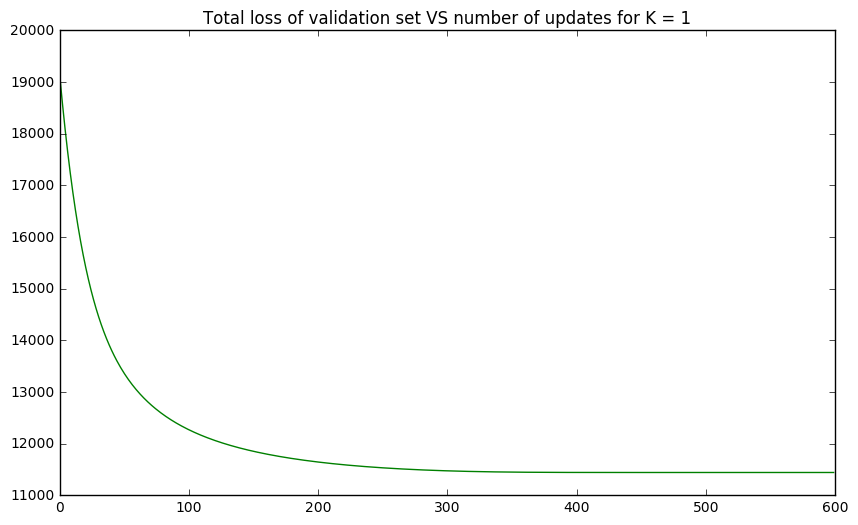

Number of cluster: 2, Iteration#: 0, Validation loss: 13125.36
Number of cluster: 2, Iteration#: 100, Validation loss: 11494.31
Number of cluster: 2, Iteration#: 200, Validation loss: 9038.16
Number of cluster: 2, Iteration#: 300, Validation loss: 8022.64
Number of cluster: 2, Iteration#: 400, Validation loss: 8021.77
Number of cluster: 2, Iteration#: 500, Validation loss: 8021.77
diag_stdev:  [[ 0.20342664  0.20110174]
 [ 0.92417473  1.11959064]]
pi:  [[ 0.34132197  0.658678  ]]


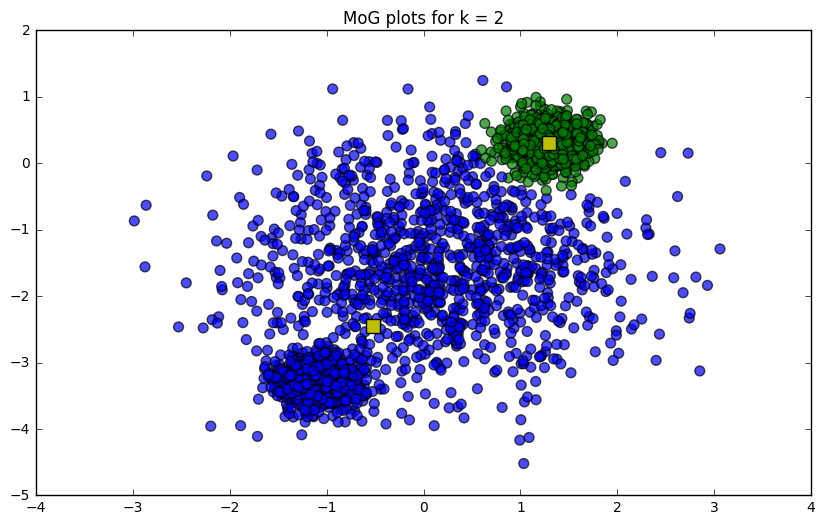

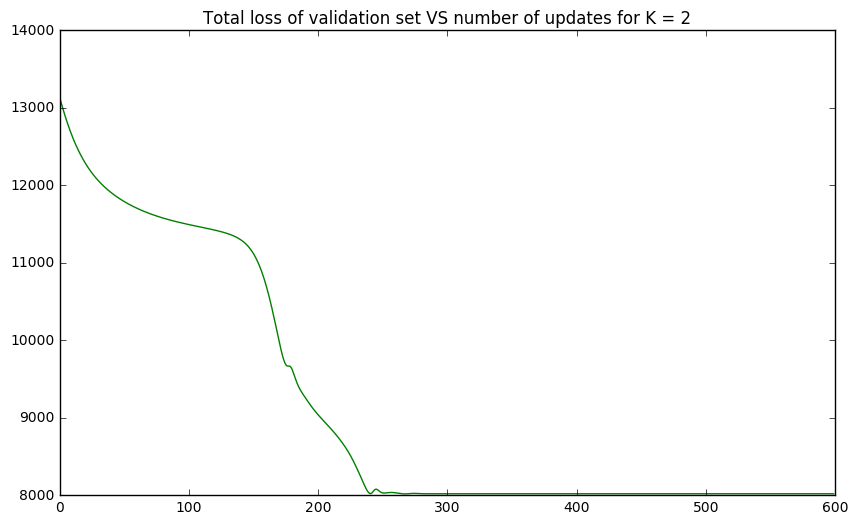

Number of cluster: 3, Iteration#: 0, Validation loss: 15539.96
Number of cluster: 3, Iteration#: 100, Validation loss: 10878.43
Number of cluster: 3, Iteration#: 200, Validation loss: 8093.44
Number of cluster: 3, Iteration#: 300, Validation loss: 7490.75
Number of cluster: 3, Iteration#: 400, Validation loss: 6310.60
Number of cluster: 3, Iteration#: 500, Validation loss: 5683.54
diag_stdev:  [[ 0.19931678  0.19864798]
 [ 0.19735801  0.19463493]
 [ 1.00166655  1.00533366]]
pi:  [[ 0.33227095  0.33357218  0.3341569 ]]


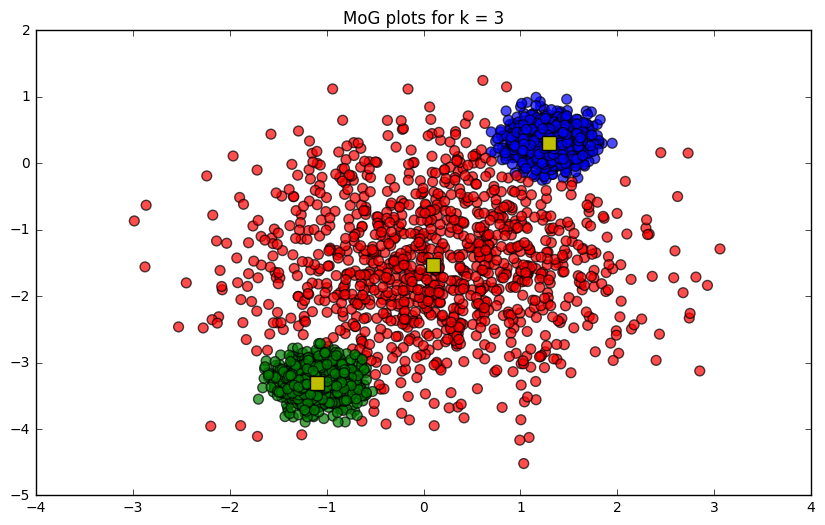

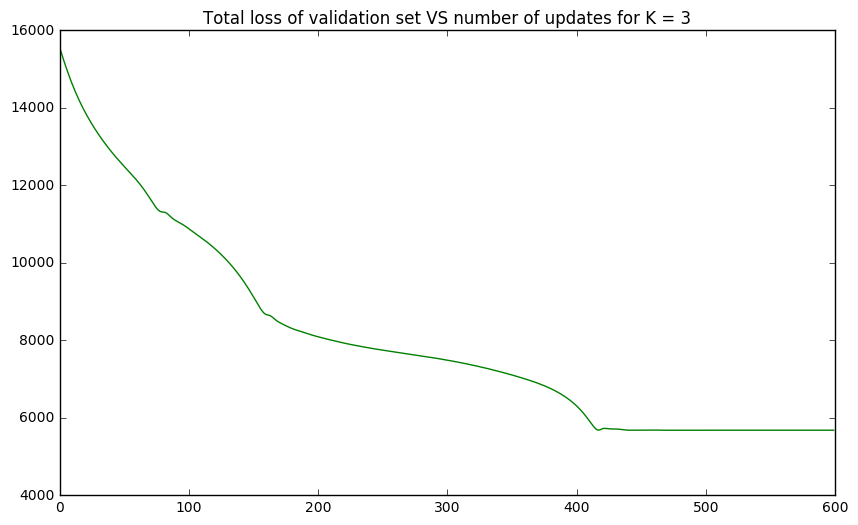

Number of cluster: 4, Iteration#: 0, Validation loss: 13990.87
Number of cluster: 4, Iteration#: 100, Validation loss: 9236.98
Number of cluster: 4, Iteration#: 200, Validation loss: 6710.37
Number of cluster: 4, Iteration#: 300, Validation loss: 5699.30
Number of cluster: 4, Iteration#: 400, Validation loss: 5688.35
Number of cluster: 4, Iteration#: 500, Validation loss: 5684.95
diag_stdev:  [[ 0.8332876   1.08503425]
 [ 0.1994085   0.19873188]
 [ 0.19767588  0.19496216]
 [ 0.99944234  0.98896539]]
pi:  [[ 0.03156087  0.33239394  0.33412749  0.3019177 ]]


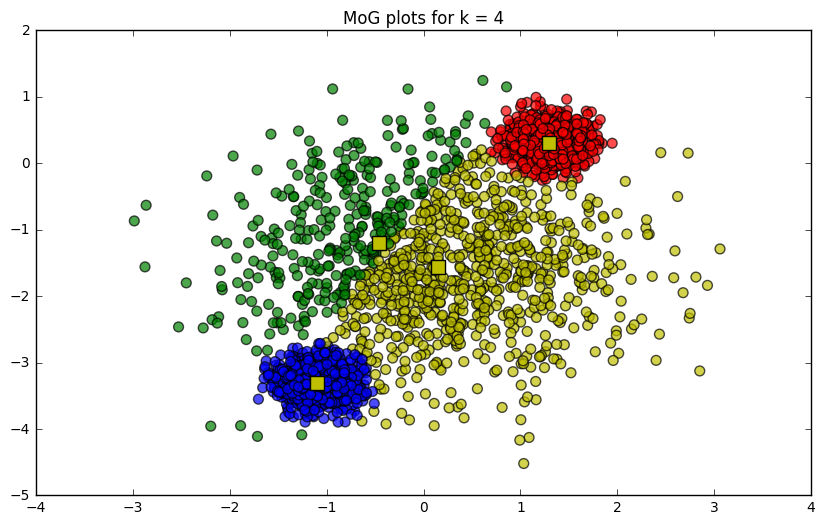

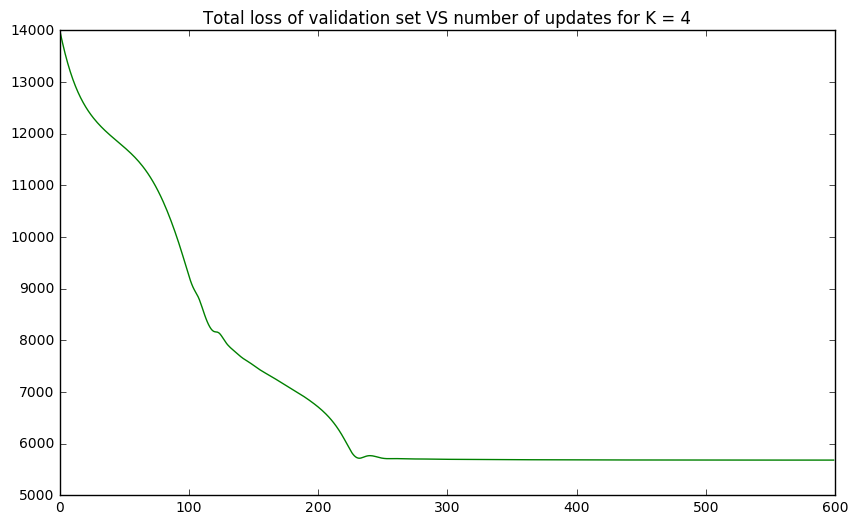

Number of cluster: 5, Iteration#: 0, Validation loss: 12696.17
Number of cluster: 5, Iteration#: 100, Validation loss: 7835.98
Number of cluster: 5, Iteration#: 200, Validation loss: 6884.95
Number of cluster: 5, Iteration#: 300, Validation loss: 5684.79
Number of cluster: 5, Iteration#: 400, Validation loss: 5683.57
Number of cluster: 5, Iteration#: 500, Validation loss: 5683.69
diag_stdev:  [[ 0.1994244   0.19874595]
 [ 0.93695056  1.00150609]
 [ 0.9822343   1.02720904]
 [ 0.19769649  0.19498859]
 [ 0.93920308  0.94926542]]
pi:  [[ 0.33242318  0.17040211  0.06877168  0.33416772  0.0942353 ]]


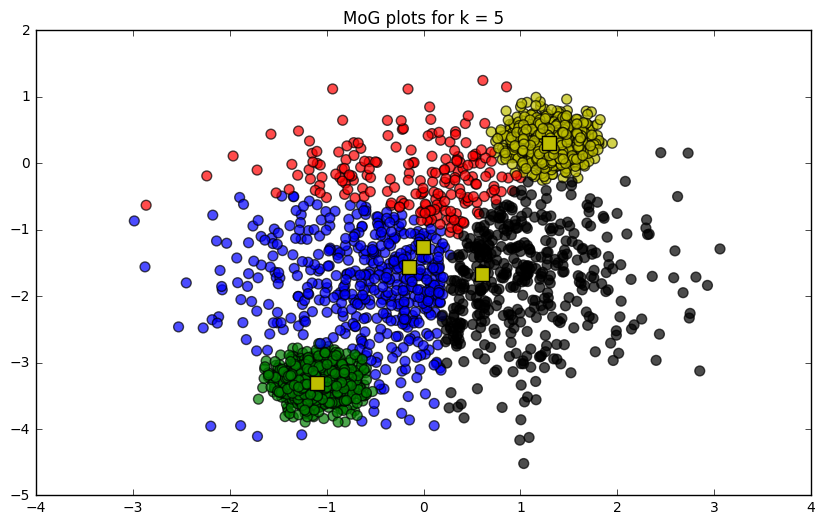

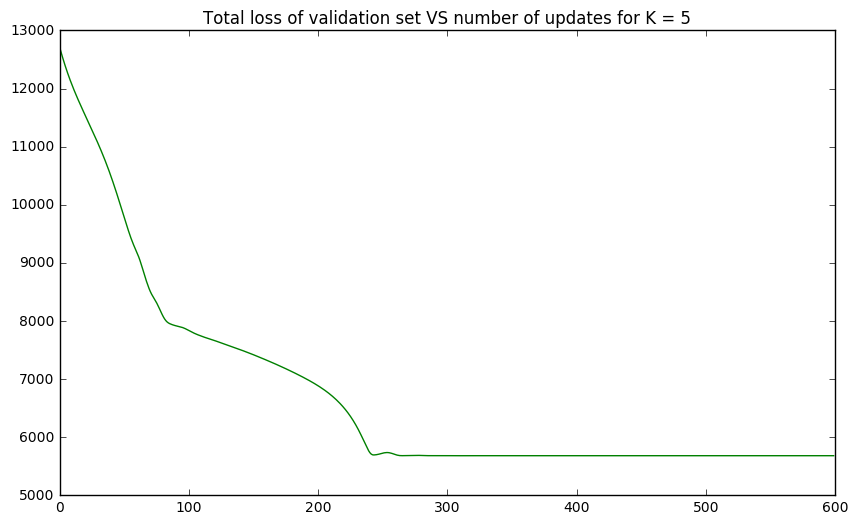

In [139]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
number_of_valid_data = validData.shape[0]
for K in K_list:
    points, pi, mu, diag_stdev, loss, train = buildGraph_MoG_Adam_2d(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    
    numIteration = 600
    pi_, mu_, diag_stdev_ = [], [], []
    for itr in range(numIteration):
        pi_,mu_,diag_stdev_,_ = sess.run([pi, mu, diag_stdev, train], feed_dict={points: trainData})
        loss_ = sess.run(loss, feed_dict={points: validData})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, Iteration#: %d, Validation loss: %0.2f"%(K, itr, loss_))
    print("diag_stdev: ", diag_stdev_)
    pi_ = sess.run(tf.exp(pi_))
    print("pi: ", pi_)
    rep_diag_stdev = tf.reshape(tf.tile(diag_stdev, [1,2]), [K,2,2])
    rep_diag_stdev = sess.run(rep_diag_stdev)
    x = validData[:,0]
    y = validData[:,1]
    #print(pi_, mu_, diag_stdev_)
    assign = get_MoG_assign(points, pi_, mu_, diag_stdev_)
    assign = sess.run(assign, feed_dict={points: validData})
    #print(assign)
    colors = [color_list[assign[i]] for i in range(number_of_valid_data)]
    plt.scatter(x,y,c=colors,alpha=0.7,s=50)
    plt.scatter(mu_[:,0],mu_[:,1],marker='s', c="y",s=100)

    #plt.axis([0,500, 0, 2])
    plt.title("MoG plots for k = %d"%(K))
    plt.show()
    
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss of validation set VS number of updates for K = %d"%(K))
    plt.show()

<h3>2.2.4</h3>

In [140]:
points_100d = np.load("../data/data100D.npy")

In [141]:
Number_of_data = points_100d.shape[0]
validSize = int(Number_of_data * 1.0 / 3.0)
validData = points_100d[:validSize,:]
trainData = points_100d[validSize:,:]
print(validData)

[[-0.10302101 -1.25855529 -1.07682836 ..., -0.3344036  -0.8396759
   1.01970744]
 [ 0.76420188 -1.03587663 -1.43337035 ...,  0.27306277 -1.27968597
   1.79634035]
 [-1.89033902 -0.19838578 -0.18936551 ..., -1.10642648  0.80143613
   0.35418662]
 ..., 
 [ 0.74477154  0.4648951   0.70218754 ...,  0.52829725  0.10996841
  -1.22521162]
 [-0.29066968  0.79323816  0.55533499 ...,  0.49830598 -0.84493768
  -0.46103576]
 [-1.78428316 -0.53080934  0.04283287 ..., -1.24885917  1.59761763
   0.71597099]]


In [142]:
def buildGraph_K_means_Adam_100d(K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 100], name='input_points')
    centroids = tf.Variable(tf.truncated_normal(shape=[K,100], stddev=0.5), name='centroids')
    N = tf.shape(points)[0]
    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 100])
    rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, 100])
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), reduction_indices=2)
    best_centroids = tf.argmin(sum_squares, 1)
    count = tf.to_float(tf.unsorted_segment_sum(tf.ones_like(points), best_centroids, K))
    percentage = tf.div(count, tf.to_float(N))
    # Loss definition
    indices_pair = tf.concat(1, [tf.reshape(tf.range(0, N), [-1,1]), tf.to_int32(tf.reshape(best_centroids, [-1,1]))])
    loss = tf.reduce_sum(tf.gather_nd(sum_squares, indices_pair))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, centroids, best_centroids, loss, percentage, train

Number of cluster: 1, Iteration#: 0, Validation loss: 404478.25
Number of cluster: 1, Iteration#: 100, Validation loss: 335041.78
Number of cluster: 1, Iteration#: 200, Validation loss: 334317.44
Number of cluster: 1, Iteration#: 300, Validation loss: 334317.56
Number of cluster: 1, Iteration#: 400, Validation loss: 334317.59


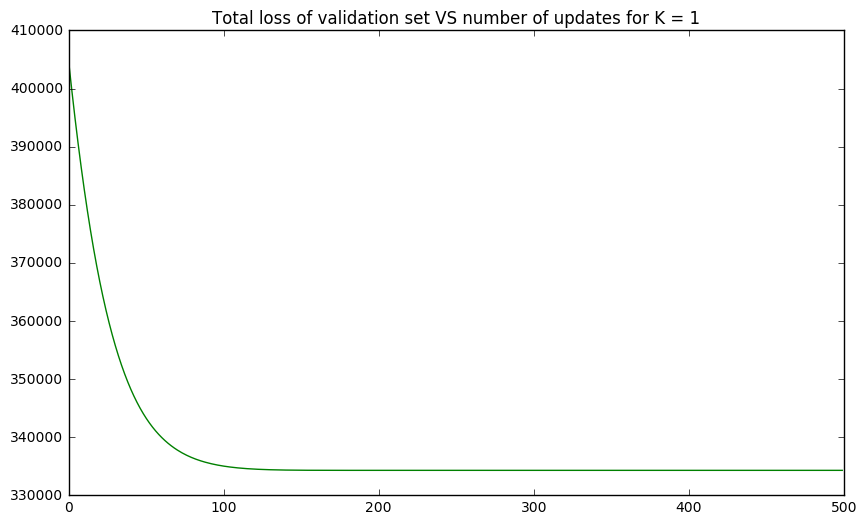

Number of cluster: 2, Iteration#: 0, Validation loss: 367669.81
Number of cluster: 2, Iteration#: 100, Validation loss: 266442.06
Number of cluster: 2, Iteration#: 200, Validation loss: 261968.33
Number of cluster: 2, Iteration#: 300, Validation loss: 261816.56
Number of cluster: 2, Iteration#: 400, Validation loss: 261814.67


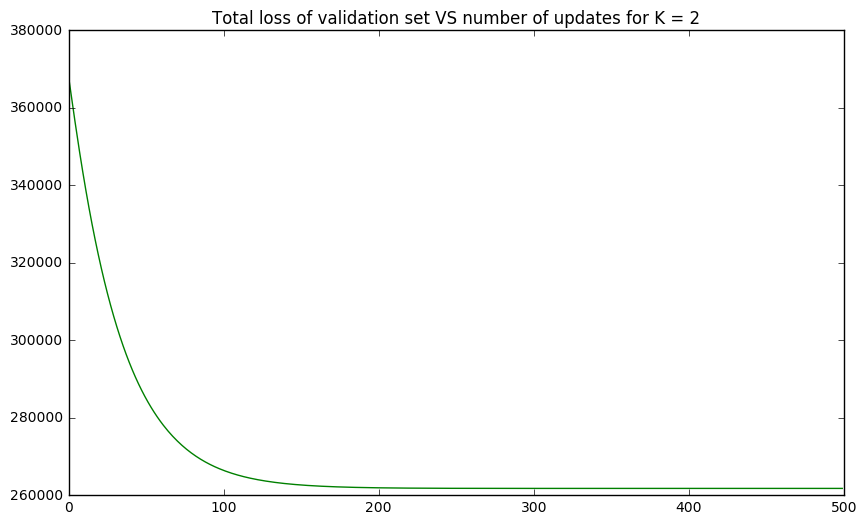

Number of cluster: 3, Iteration#: 0, Validation loss: 371694.47
Number of cluster: 3, Iteration#: 100, Validation loss: 209234.23
Number of cluster: 3, Iteration#: 200, Validation loss: 191181.58
Number of cluster: 3, Iteration#: 300, Validation loss: 189628.89
Number of cluster: 3, Iteration#: 400, Validation loss: 189571.47


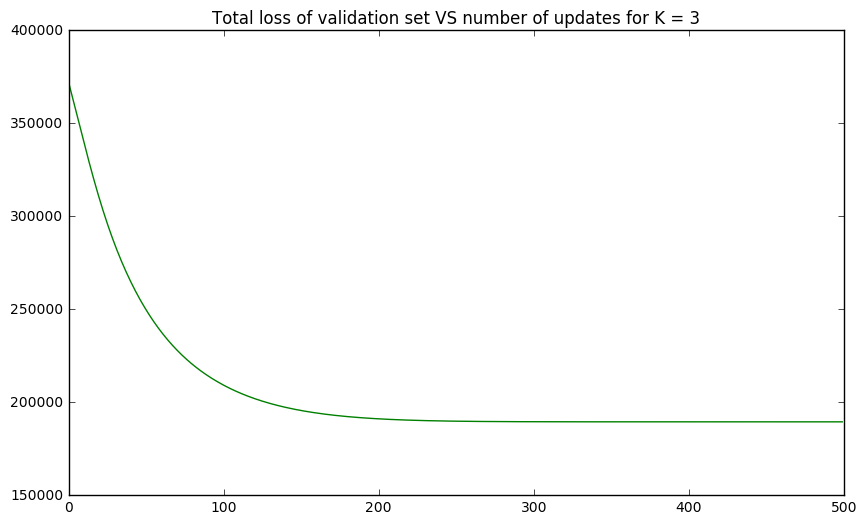

Number of cluster: 4, Iteration#: 0, Validation loss: 367187.28
Number of cluster: 4, Iteration#: 100, Validation loss: 200420.73
Number of cluster: 4, Iteration#: 200, Validation loss: 188243.19
Number of cluster: 4, Iteration#: 300, Validation loss: 187643.41
Number of cluster: 4, Iteration#: 400, Validation loss: 187627.55


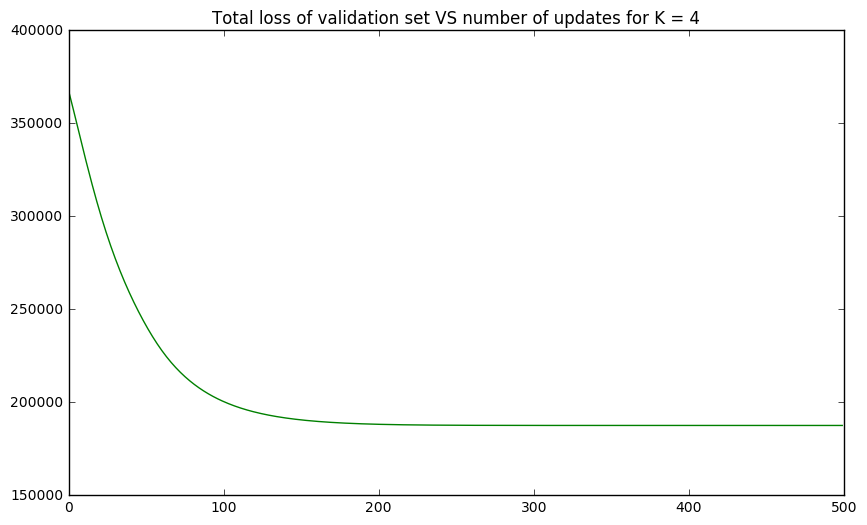

Number of cluster: 5, Iteration#: 0, Validation loss: 356535.97
Number of cluster: 5, Iteration#: 100, Validation loss: 169051.14
Number of cluster: 5, Iteration#: 200, Validation loss: 147169.00
Number of cluster: 5, Iteration#: 300, Validation loss: 144187.23
Number of cluster: 5, Iteration#: 400, Validation loss: 143807.95


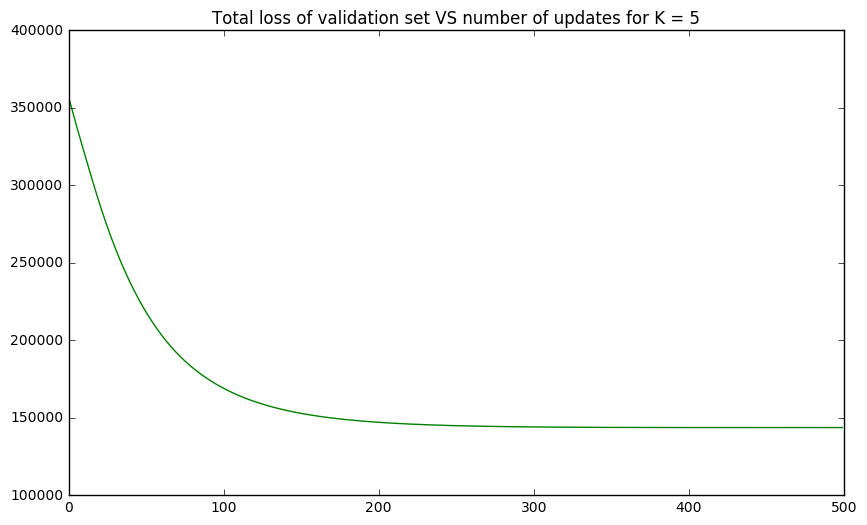

In [143]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam_100d(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    
    numIteration = 500
    for itr in range(numIteration):
        _ = sess.run([train], feed_dict={points: trainData})
        loss_ = sess.run(loss, feed_dict={points: validData})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, Iteration#: %d, Validation loss: %0.2f"%(K, itr, loss_))
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss of validation set VS number of updates for K = %d"%(K))
    plt.show()

In [144]:
def buildGraph_MoG_Adam_100d(K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 100], name='input_points')
    mu = tf.Variable(tf.truncated_normal(shape=[K,100], stddev=0.5), name='mu')
    diag_stdev = tf.Variable(tf.exp(tf.truncated_normal(shape=[K,100], stddev=0.5)), name='diag_stdev')
    phi = tf.Variable(tf.truncated_normal(shape=[1,K], stddev=0.5), name='phi')
    pi = logsoftmax(phi)
    
    # Loss definition
    loss = -get_log_P(points, pi, mu, diag_stdev)
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, pi, mu, diag_stdev, loss, train

Number of cluster: 1, Iteration#: 0, Validation loss: 592750.81
Number of cluster: 1, Iteration#: 100, Validation loss: 474945.69
Number of cluster: 1, Iteration#: 200, Validation loss: 473508.22
Number of cluster: 1, Iteration#: 300, Validation loss: 473476.84
Number of cluster: 1, Iteration#: 400, Validation loss: 473475.91
Number of cluster: 1, Iteration#: 500, Validation loss: 473475.97


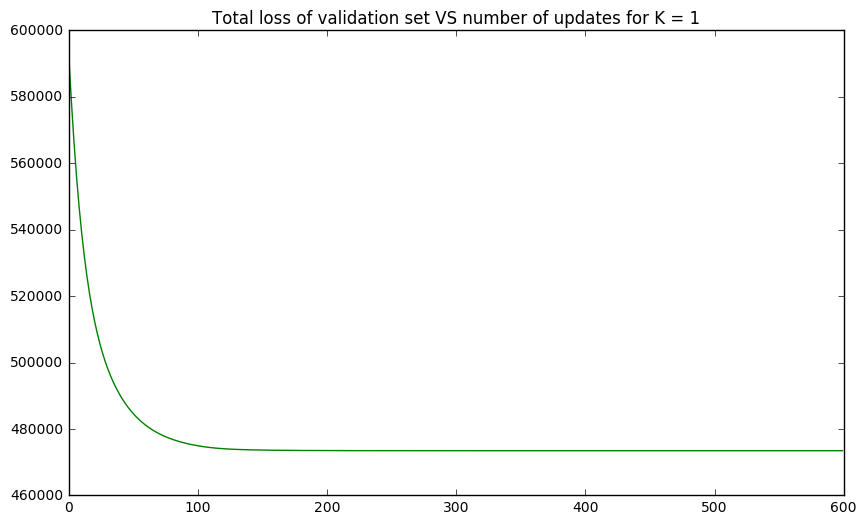

Number of cluster: 2, Iteration#: 0, Validation loss: 564538.06
Number of cluster: 2, Iteration#: 100, Validation loss: 396195.69
Number of cluster: 2, Iteration#: 200, Validation loss: 380964.72
Number of cluster: 2, Iteration#: 300, Validation loss: 379761.50
Number of cluster: 2, Iteration#: 400, Validation loss: 379744.75
Number of cluster: 2, Iteration#: 500, Validation loss: 379744.59


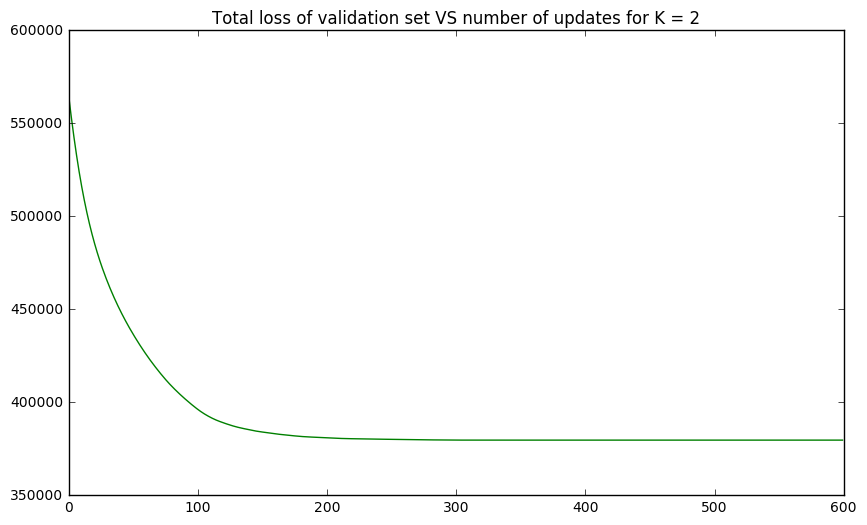

Number of cluster: 3, Iteration#: 0, Validation loss: 546735.62
Number of cluster: 3, Iteration#: 100, Validation loss: 358174.81
Number of cluster: 3, Iteration#: 200, Validation loss: 337987.66
Number of cluster: 3, Iteration#: 300, Validation loss: 336810.88
Number of cluster: 3, Iteration#: 400, Validation loss: 336763.56
Number of cluster: 3, Iteration#: 500, Validation loss: 336763.59


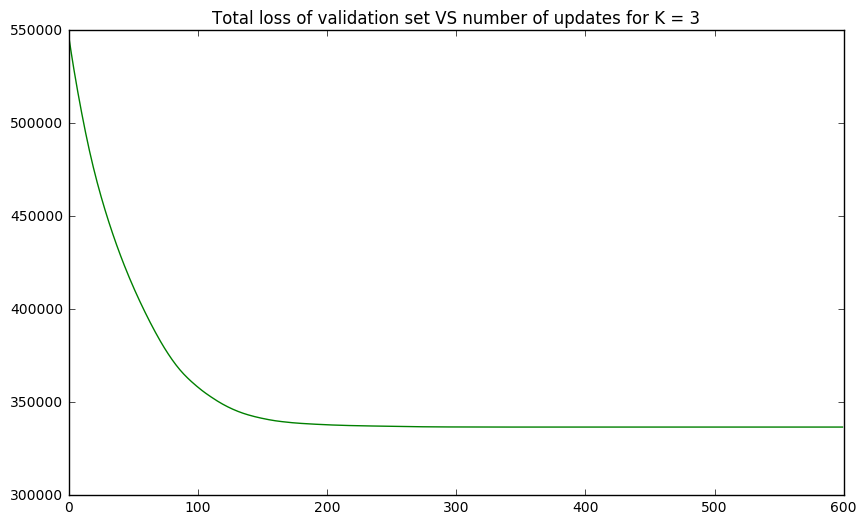

Number of cluster: 4, Iteration#: 0, Validation loss: 559232.19
Number of cluster: 4, Iteration#: 100, Validation loss: 278454.47
Number of cluster: 4, Iteration#: 200, Validation loss: 219491.91
Number of cluster: 4, Iteration#: 300, Validation loss: 210865.89
Number of cluster: 4, Iteration#: 400, Validation loss: 207224.67
Number of cluster: 4, Iteration#: 500, Validation loss: 207054.89


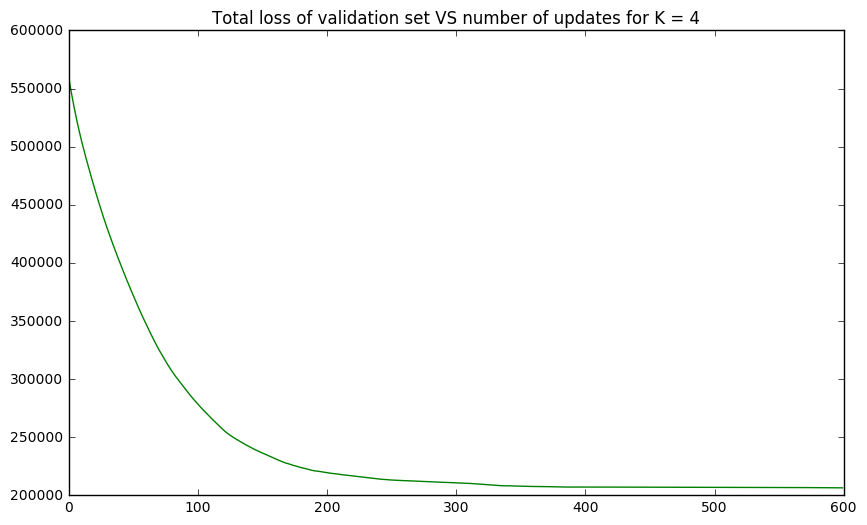

Number of cluster: 5, Iteration#: 0, Validation loss: 555656.69
Number of cluster: 5, Iteration#: 100, Validation loss: 287528.25
Number of cluster: 5, Iteration#: 200, Validation loss: 234823.03
Number of cluster: 5, Iteration#: 300, Validation loss: 228647.14
Number of cluster: 5, Iteration#: 400, Validation loss: 228429.44
Number of cluster: 5, Iteration#: 500, Validation loss: 228417.55


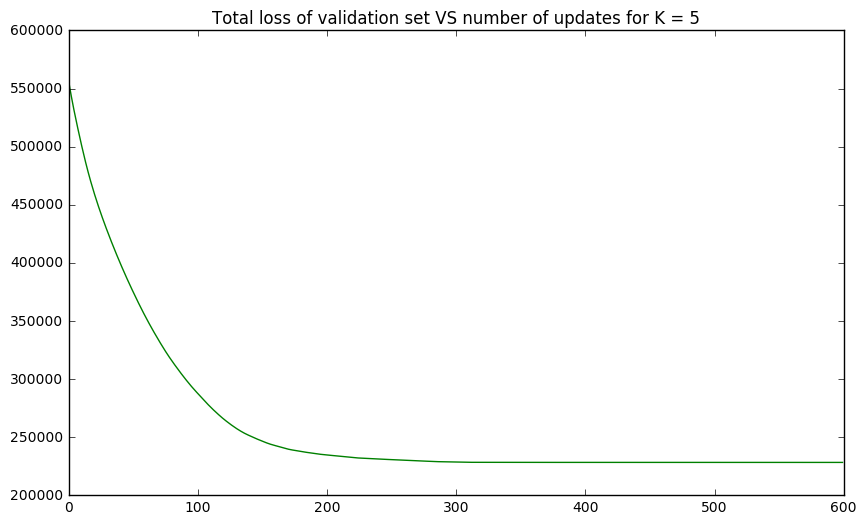

In [145]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
number_of_valid_data = validData.shape[0]
for K in K_list:
    points, pi, mu, diag_stdev, loss, train = buildGraph_MoG_Adam_100d(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    
    numIteration = 600
    pi_, mu_, diag_stdev_ = [], [], []
    for itr in range(numIteration):
        pi_,mu_,diag_stdev_,_ = sess.run([pi, mu, diag_stdev, train], feed_dict={points: trainData})
        loss_ = sess.run(loss, feed_dict={points: validData})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, Iteration#: %d, Validation loss: %0.2f"%(K, itr, loss_))
    x = validData[:,0]
    y = validData[:,1]

    
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss of validation set VS number of updates for K = %d"%(K))
    plt.show()

<h3>3.2</h3>

In [3]:
data = np.load ("../data/tinymnist.npz")
trainData, trainTarget = data ["x"], data["y"]
validData, validTarget = data ["x_valid"], data ["y_valid"]
testData, testTarget = data ["x_test"], data ["y_test"]
print(trainData.shape)

(700, 64)


In [210]:
w = tf.constant([[[1,2],[1,2],[1,2]],[[1,2],[1,2],[1,2]]],dtype=tf.float32)
w_t = tf.matrix_transpose(w)
mu = tf.Variable(tf.truncated_normal(shape=[2,3], stddev=0.5), name='mu_test1')
phi = tf.matrix_diag(tf.constant([[1,2,3],[1,2,3]],dtype=tf.float32))
cov_sqrt = tf.cholesky(tf.add(phi, tf.matmul(w, w_t)))
dist = tf.contrib.distributions.MultivariateNormalCholesky(mu, cov_sqrt)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
sess.run(dist.pdf(dist.sample(3)))

array([[ 0.00209655,  0.00043591],
       [ 0.0018715 ,  0.00096866],
       [ 0.00087755,  0.00062126]], dtype=float32)

In [51]:
def get_log_P_FA(X, mu, diag_stdev, W):
    '''
    X: BxD
    mu: KxD
    diag_stdev: KxD
    W: KxDxK
    B: number of data points
    D: dimension of a data point
    K: number of clusters
    return log_p
    '''
    
    B = tf.shape(X)[0]
    D = tf.shape(X)[1]
    K = tf.shape(mu)[0]
    phi = tf.matrix_diag(diag_stdev)
    W_T = tf.matrix_transpose(W)
    cov_sqrt = tf.add(phi, tf.matmul(W, W_T))
    cholesky_cov = tf.cholesky(cov_sqrt)
    rep_X = tf.reshape(tf.tile(X, [1, K]), [B, K, D])
    dist = tf.contrib.distributions.MultivariateNormalCholesky(mu, cholesky_cov)
    log_pdf = dist.log_pdf(rep_X)
    res = tf.reduce_sum(log_pdf)
    return res

In [52]:
K = 4
learning_rate = 0.01
loss_recorder = np.array([])
tf.reset_default_graph()
points = tf.placeholder(tf.float64, [None, 64], name='input_points_test')
mu = tf.Variable(tf.truncated_normal(shape=[K,64], stddev=0.5, dtype=tf.float64), name='mu_test')
diag_stdev = tf.Variable(tf.exp(tf.ones(shape=[K,64],dtype=tf.float64)*2), name='diag_stdev_test')
W = tf.Variable(tf.truncated_normal(shape=[K,64,K], stddev=0.5, dtype=tf.float64), name='weight_test')
loss = -get_log_P_FA(points, mu, diag_stdev, W)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)

train = optimizer.minimize(loss=loss)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
numIteration = 500
for itr in range(numIteration):
    diag_stdev_, loss_, _ = sess.run([diag_stdev, loss, train], feed_dict={points: trainData})
    loss_recorder = np.append(loss_recorder, loss_)
    if itr % 100 == 0:
        print("Iteration#: %d, loss: %0.2f"%(itr, loss_))

Iteration#: 0, loss: 353789.21
Iteration#: 100, loss: 331413.22
Iteration#: 200, loss: 314692.92
Iteration#: 300, loss: 293296.76
Iteration#: 400, loss: 263409.77


In [53]:
def buildGraph_FA_Adam(K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 64], name='input_points')
    mu = tf.Variable(tf.truncated_normal(shape=[K,64], stddev=0.5), name='mu')
    diag_stdev = tf.Variable(tf.exp(tf.truncated_normal(shape=[K,64], stddev=0.5)), name='diag_stdev')
    W = tf.Variable(tf.truncated_normal(shape=[K,64,K], stddev=0.5), name='weight')
    
    # Loss definition
    loss = -get_log_P_FA(points, mu, diag_stdev, W)
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, mu, diag_stdev, W, loss, train

In [56]:
learning_rate = 0.001
tf.reset_default_graph()
points, mu, diag_stdev, W, loss, train = buildGraph_FA_Adam(4, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
loss_recorder = np.array([])

numIteration = 2000
for itr in range(numIteration):
    loss_, _ = sess.run([loss, train], feed_dict={points: trainData})
    loss_recorder = np.append(loss_recorder, loss_)
    if itr % 100 == 0:
        print("Iteration#: %d, loss: %0.2f"%(itr, loss_))
        print("Mean matrix is:")
        print(mu_)
        print("Weight matrix is:")
        print(W_)
plt.plot(np.arange(numIteration), loss_recorder, 'g')
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

Iteration#: 0, loss: 208152.44
Mean matrix is:


NameError: name 'mu_' is not defined